# <font color='blue'>**Result Analysis**</font> 

In [24]:
from galapy.sampling.Results import load_results

In [25]:
res = load_results('data/sampling_4D+noise_dynesty_results_light.galapy.hdf5')
#res = load_results('202403272356_dynesty_results_light.galapy.hdf5')

Read from file data/sampling_4D+noise_dynesty_results_light.galapy.hdf5
Now processing the sampling results, this might require some time ...
... done in 67.36293506622314 seconds.


In [26]:
model = res.get_model()
observation = res.get_observation()
handler = res.get_handler()
print('The run has ', res.Ndof, 'degrees of freedom')

The run has  19 degrees of freedom


In [27]:
res.get_stored_quantities()

['_mod',
 '_han',
 'Ndof',
 '_obs',
 '_noise',
 'sampler',
 'ndim',
 'size',
 'params',
 'logl',
 'samples',
 'weights',
 'wnot0',
 'SED',
 'Mstar',
 'Mdust',
 'Mgas',
 'Zstar',
 'Zgas',
 'SFR',
 'TMC',
 'TDD']

In [28]:
print(f"Best-fitting stellar mass: {res.get_bestfit('Mstar'):.2e} Msol")

Best-fitting stellar mass: 3.97e+09 Msol


In [29]:
print(f"Median stellar mass: {res.get_median('Mstar'):.2e} Msol")

Median stellar mass: 4.11e+09 Msol


In [30]:
handler.par_prior, handler.par_free, handler.par_log

(array([[  8.,  10.],
        [  0.,   5.],
        [  0.,   3.],
        [  7.,  10.],
        [-10.,   1.]]),
 array(['galaxy.age', 'galaxy.redshift', 'galaxy.sfh.psi_max',
        'galaxy.sfh.tau_star', 'noise.f_cal'], dtype='<U19'),
 array([ True, False,  True,  True,  True]))

# <font color='blue'>**Plots**</font> 

In [31]:
import galapy.analysis.plot as gplot

In [32]:
from galapy.analysis.plot import plt

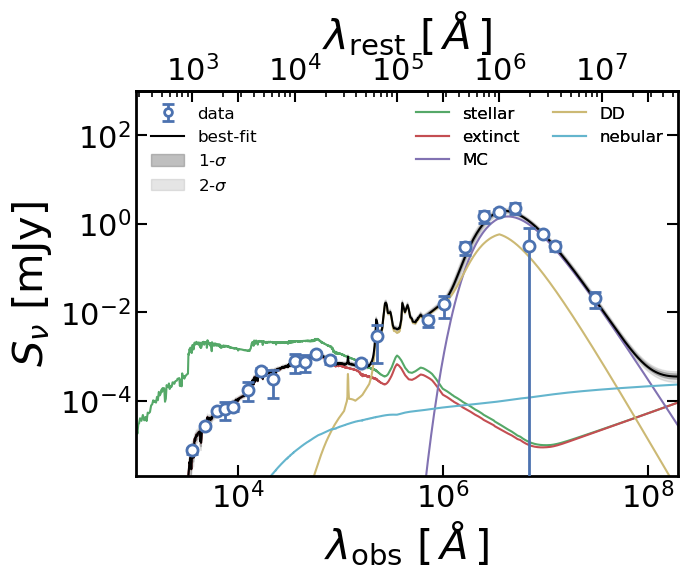

In [33]:
ax = gplot.sed_flux_res(
    res, plot_components=True, plot_observation=True, plot_contours=True,
    ax_kwargs = {
       'xlim':(1.e+3, 2.e+8),
       'ylim':(2.e-6,1.e+3),
    },
    legend_kwargs = {
        'l1': {'loc': 'upper left', 'fontsize':12},
        'l2': {'loc': 'upper right', 'ncol': 2, 'fontsize': 12}
    }
)

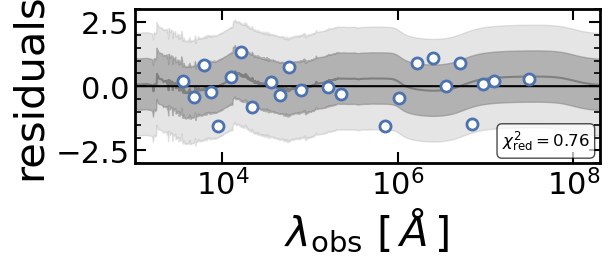

In [34]:
# we can also build matplotlib figure and axes before calling the function
# e.g. if we want to overwrite the default figure size:
fig, ax = plt.subplots(1,1,figsize=(6,2))

# it is then sufficient to pass the generated axes to the galapy function:
_ = gplot.sed_residuals_res(
    res, frame='obs', plot_contours=True, plot_chi2 = True,
    ax = ax, # <------ here!
    ax_kwargs={
        'xlim':(1.e+3, 2.e+8),
        'ylim':(-3., +3.)
    },
    text_kwargs={'loc':'lower right'}
)


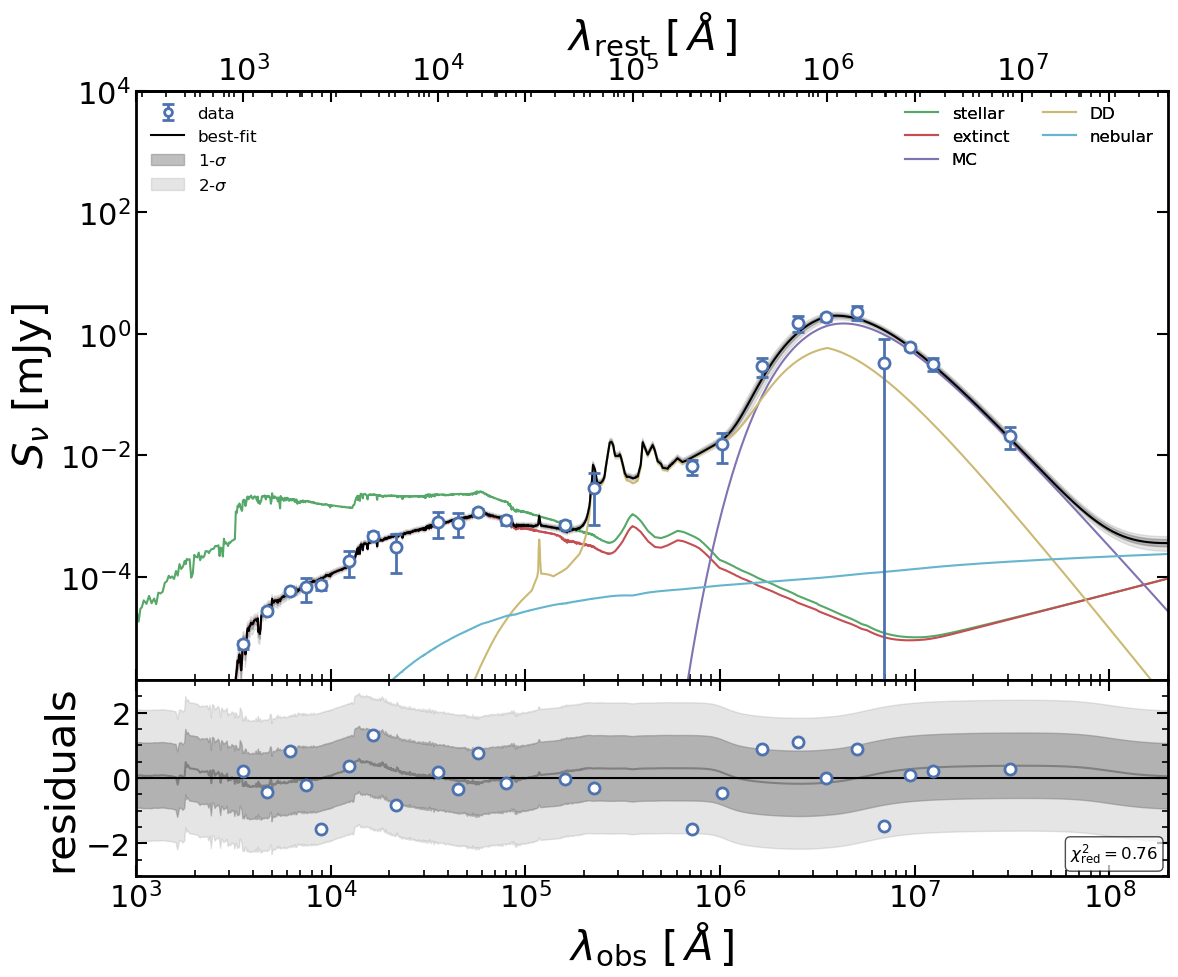

In [35]:
fig, axes = plt.subplots(2,1,figsize=(12,10),tight_layout=True,
                                      sharex = True,
                         gridspec_kw={'height_ratios':(4.5,1.5), 'hspace':0.0})

###################################################
# Plot the SED:

_ = gplot.sed_flux_res(
    res, plot_components=True, plot_observation=True, plot_contours=True,
    ax = axes[0], # passing the first Axis to the ax argument
    ax_kwargs = {
       'xlim':(1.e+3, 2.e+8),
       'ylim':(2.e-6,1.e+4),
    },
    legend_kwargs = {
        'l1': {'loc': 'upper left', 'fontsize':12},
        'l2': {'loc': 'upper right', 'ncol': 2, 'fontsize': 12}
    }
)

###################################################
# Plot the residuals

_ = gplot.sed_residuals_res(
    res, frame='obs', plot_contours=True, plot_chi2 = True,
    ax = axes[1], # passing the second Axis to the ax argument
    ax_kwargs={
        'xlim':(1.e+3, 2.e+8),
        'ylim':(-3., +3.)
    },
    text_kwargs={'loc':'lower right'}
)

# <font color='blue'>**Plot the derived attenuation curve**</font> 

In [36]:
from galapy.internal.utils import find_nearest
ll = model.wl()
w5500 = find_nearest(ll, 5500) # index in the wavelength grid corresponding to 5500 Angstrom

In [37]:
model.set_parameters(**res.get_bestfit('params'))

In [38]:
_ = model.get_emission()

In [39]:
Abest = model.get_avgAtt()
Abest /= Abest[w5500]

In [40]:
import numpy
def att_calzetti ( ll, Rv ) :
    """from Calzetti et al., 2000"""
    # convert angstrom to micron:
    ll = numpy.array(ll) * 1.e-4
    kp = 2.659 * ( - 2.156 + 1.509 / ll - 0.198 / ll**2. + 0.011 / ll**3. ) + Rv
    wl = numpy.where( ll >= 0.63 )
    kp[wl] = 2.659 * ( - 1.857 + 1.04 / ll[wl] ) + Rv
    return kp / Rv

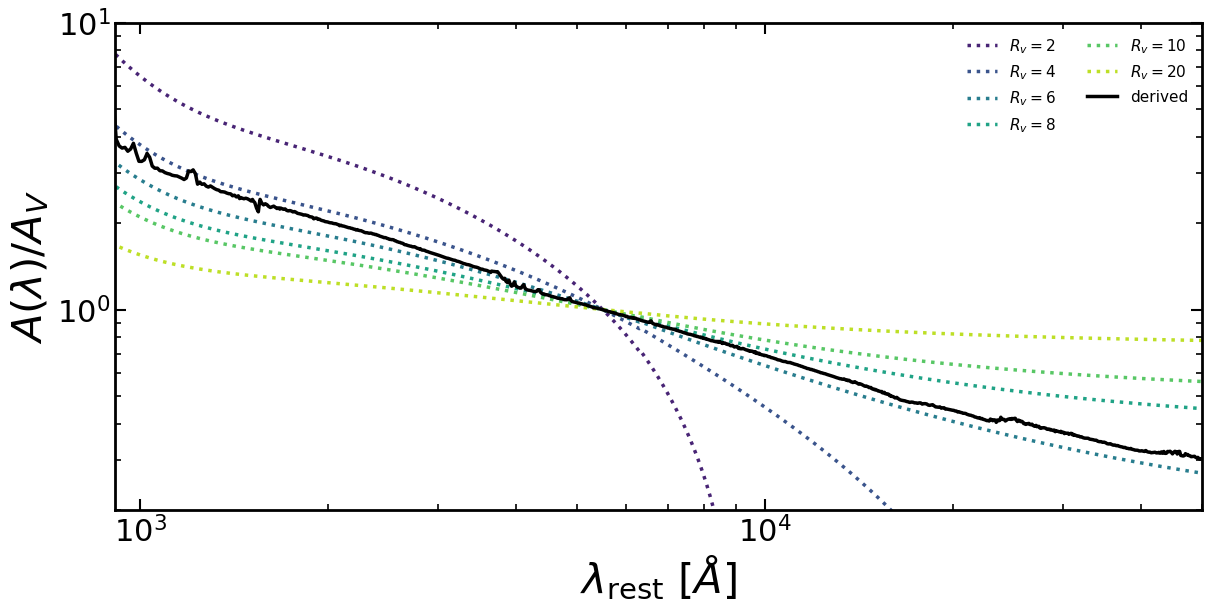

In [41]:
# Plot set-up
fig, ax = plt.subplots(1,1,figsize=(12,6),constrained_layout=True)
ax.set(
    xscale='log', yscale='log',
    xlim=(9.12e+2,5.e+4), ylim=(2.e-1,1.e+1),
    xlabel='$\\lambda_\\mathrm{rest}\\ [\\AA]$',
    ylabel='$A(\\lambda)/A_V$',
)

#########################
# Plot Calzetti reference

# Get a sequence of colors for values of the Rv parameter
Rvs = [ 2.,4.,6.,8.,10.,20. ]
cmaplist = plt.cm.viridis(numpy.linspace(0.1,0.9,len(Rvs)))

# Plot for each Rv value
_ = [ ax.plot(ll, att_calzetti(ll, Rv),
              color=clr, ls=':', lw=2.5, label=f'$R_v = ${Rv:.0f}')
      for Rv, clr in zip(Rvs,cmaplist) ]

##########################
# Plot derived Attenuation

ax.plot( ll, Abest, color = 'k', lw=2.5, label='derived' )

# legend
_ = ax.legend(ncol=2, fontsize=11)

# <font color='blue'>**Posteriores**</font> 

In [42]:
handler.par_free

array(['galaxy.age', 'galaxy.redshift', 'galaxy.sfh.psi_max',
       'galaxy.sfh.tau_star', 'noise.f_cal'], dtype='<U19')

Removed no burn in
Falling back to default quantiles: (0.16,0.5,0.84)


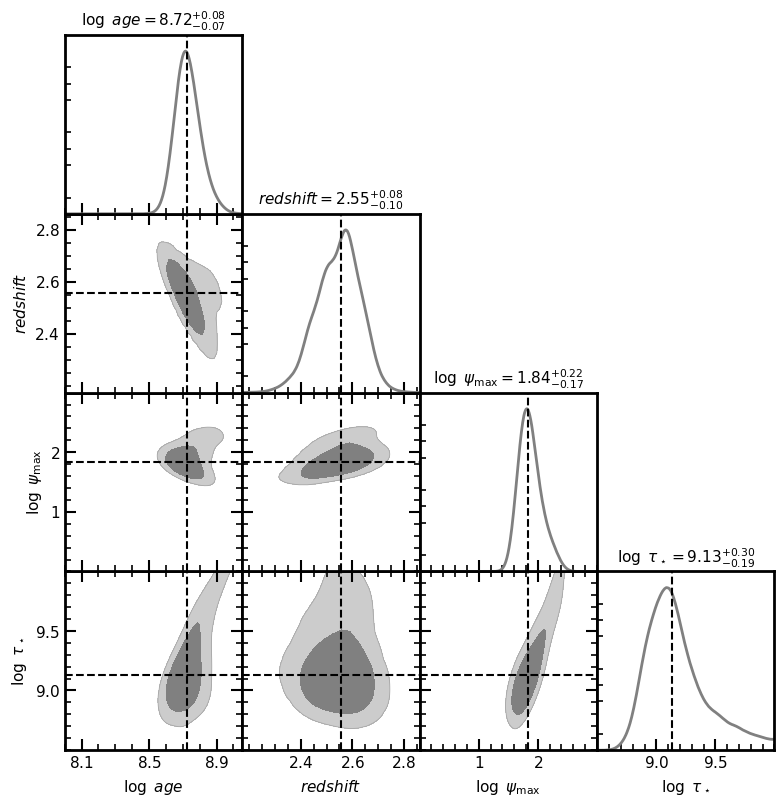

In [43]:
fig, axes = gplot.corner_res(
    res, # results object
    which_params='galaxy*', # what parameters to plot (use None for all the free parameters)
    mark = 'median', # what statistics to plot dashed lines ('median','mean' or 'bestfit')
    getdist_settings={
        'contours' : [0.68, 0.95],
        'smooth_scale_2D' : 0.5,
        'fine_bins': 1024
    },
)

# <font color='blue'>**Tables and TeX**</font> 

In [44]:
import galapy.analysis.funcs as gtabs

In [45]:
gtabs.get_parameters_label_strings(handler)

{'galaxy.age': '\\log~age',
 'galaxy.redshift': 'redshift',
 'galaxy.sfh.psi_max': '\\log~\\psi_\\mathrm{max}',
 'galaxy.sfh.tau_star': '\\log~\\tau_\\star',
 'noise.f_cal': '\\log~f_\\mathrm{cal}'}

In [46]:
gtabs.get_parameters_summary_strings(res, stat_type='quantiles', quantile=(0.025, 0.5, 0.975))

array(['8.72_{-0.13}^{+0.17}', '2.55_{-0.19}^{+0.14}',
       '1.84_{-0.29}^{+0.48}', '9.13_{-0.33}^{+0.71}',
       '-5.64_{-4.13}^{+4.41}'], dtype='<U21')